# BirdCLEF 2024 - Create Dataset of Spectrograms
* This goal is to create a dataset of spectrograms from the BirdCLEF 2024 dataset for use in training a deep learning model.
* It is created by extracting spectrograms in 5 second intervals from the audio files in the BirdCLEF 2024 dataset.
* Signals that have less than [TBD] dB of signal are discarded.
* Possibly differentiate by call types (song, call, etc.) in the future.
* For this first run, I only use files with no secondary labels, and only use files with a rating of 2 or higher.
    * And do a test on only asbfly type


# Imports

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display

import IPython.display as ipd

import tqdm.auto as tqdm


# Load Training Data

In [2]:
root_dir = '/kaggle/input/birdclef-2024/'
train = pd.read_csv(root_dir + '/train_metadata.csv')
print(f'Train shape: {train.shape}')
train.head()

Train shape: (24459, 12)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg


In [3]:
# for now, get rid of the rows with secondary labels that are not []
train = train[train['secondary_labels'] == '[]']
print(f'Train shape: {train.shape}')
train['primary_label'].value_counts().tail(10)

Train shape: (22567, 12)


primary_label
bncwoo3    7
wbbfly1    6
blaeag1    6
darter2    6
paisto1    6
wynlau1    6
malwoo1    6
integr     5
asiope1    5
niwpig1    4
Name: count, dtype: int64

In [4]:
# remove the secondary labels column, as well as scientific_name, author, license, and url
train.drop(columns=['secondary_labels','scientific_name', 'author', 'license', 'url'], inplace=True)
train.head()

,primary_label,type,latitude,longitude,common_name,rating,filename
0,asbfly,['call'],39.2297,118.1987,Asian Brown Flycatcher,5.0,asbfly/XC134896.ogg
1,asbfly,['song'],51.4030,104.6401,Asian Brown Flycatcher,2.5,asbfly/XC164848.ogg
2,asbfly,['song'],36.3319,127.3555,Asian Brown Flycatcher,2.5,asbfly/XC175797.ogg
3,asbfly,['call'],21.1697,70.6005,Asian Brown Flycatcher,4.0,asbfly/XC207738.ogg
4,asbfly,['call'],15.5442,73.7733,Asian Brown Flycatcher,4.0,asbfly/XC209218.ogg


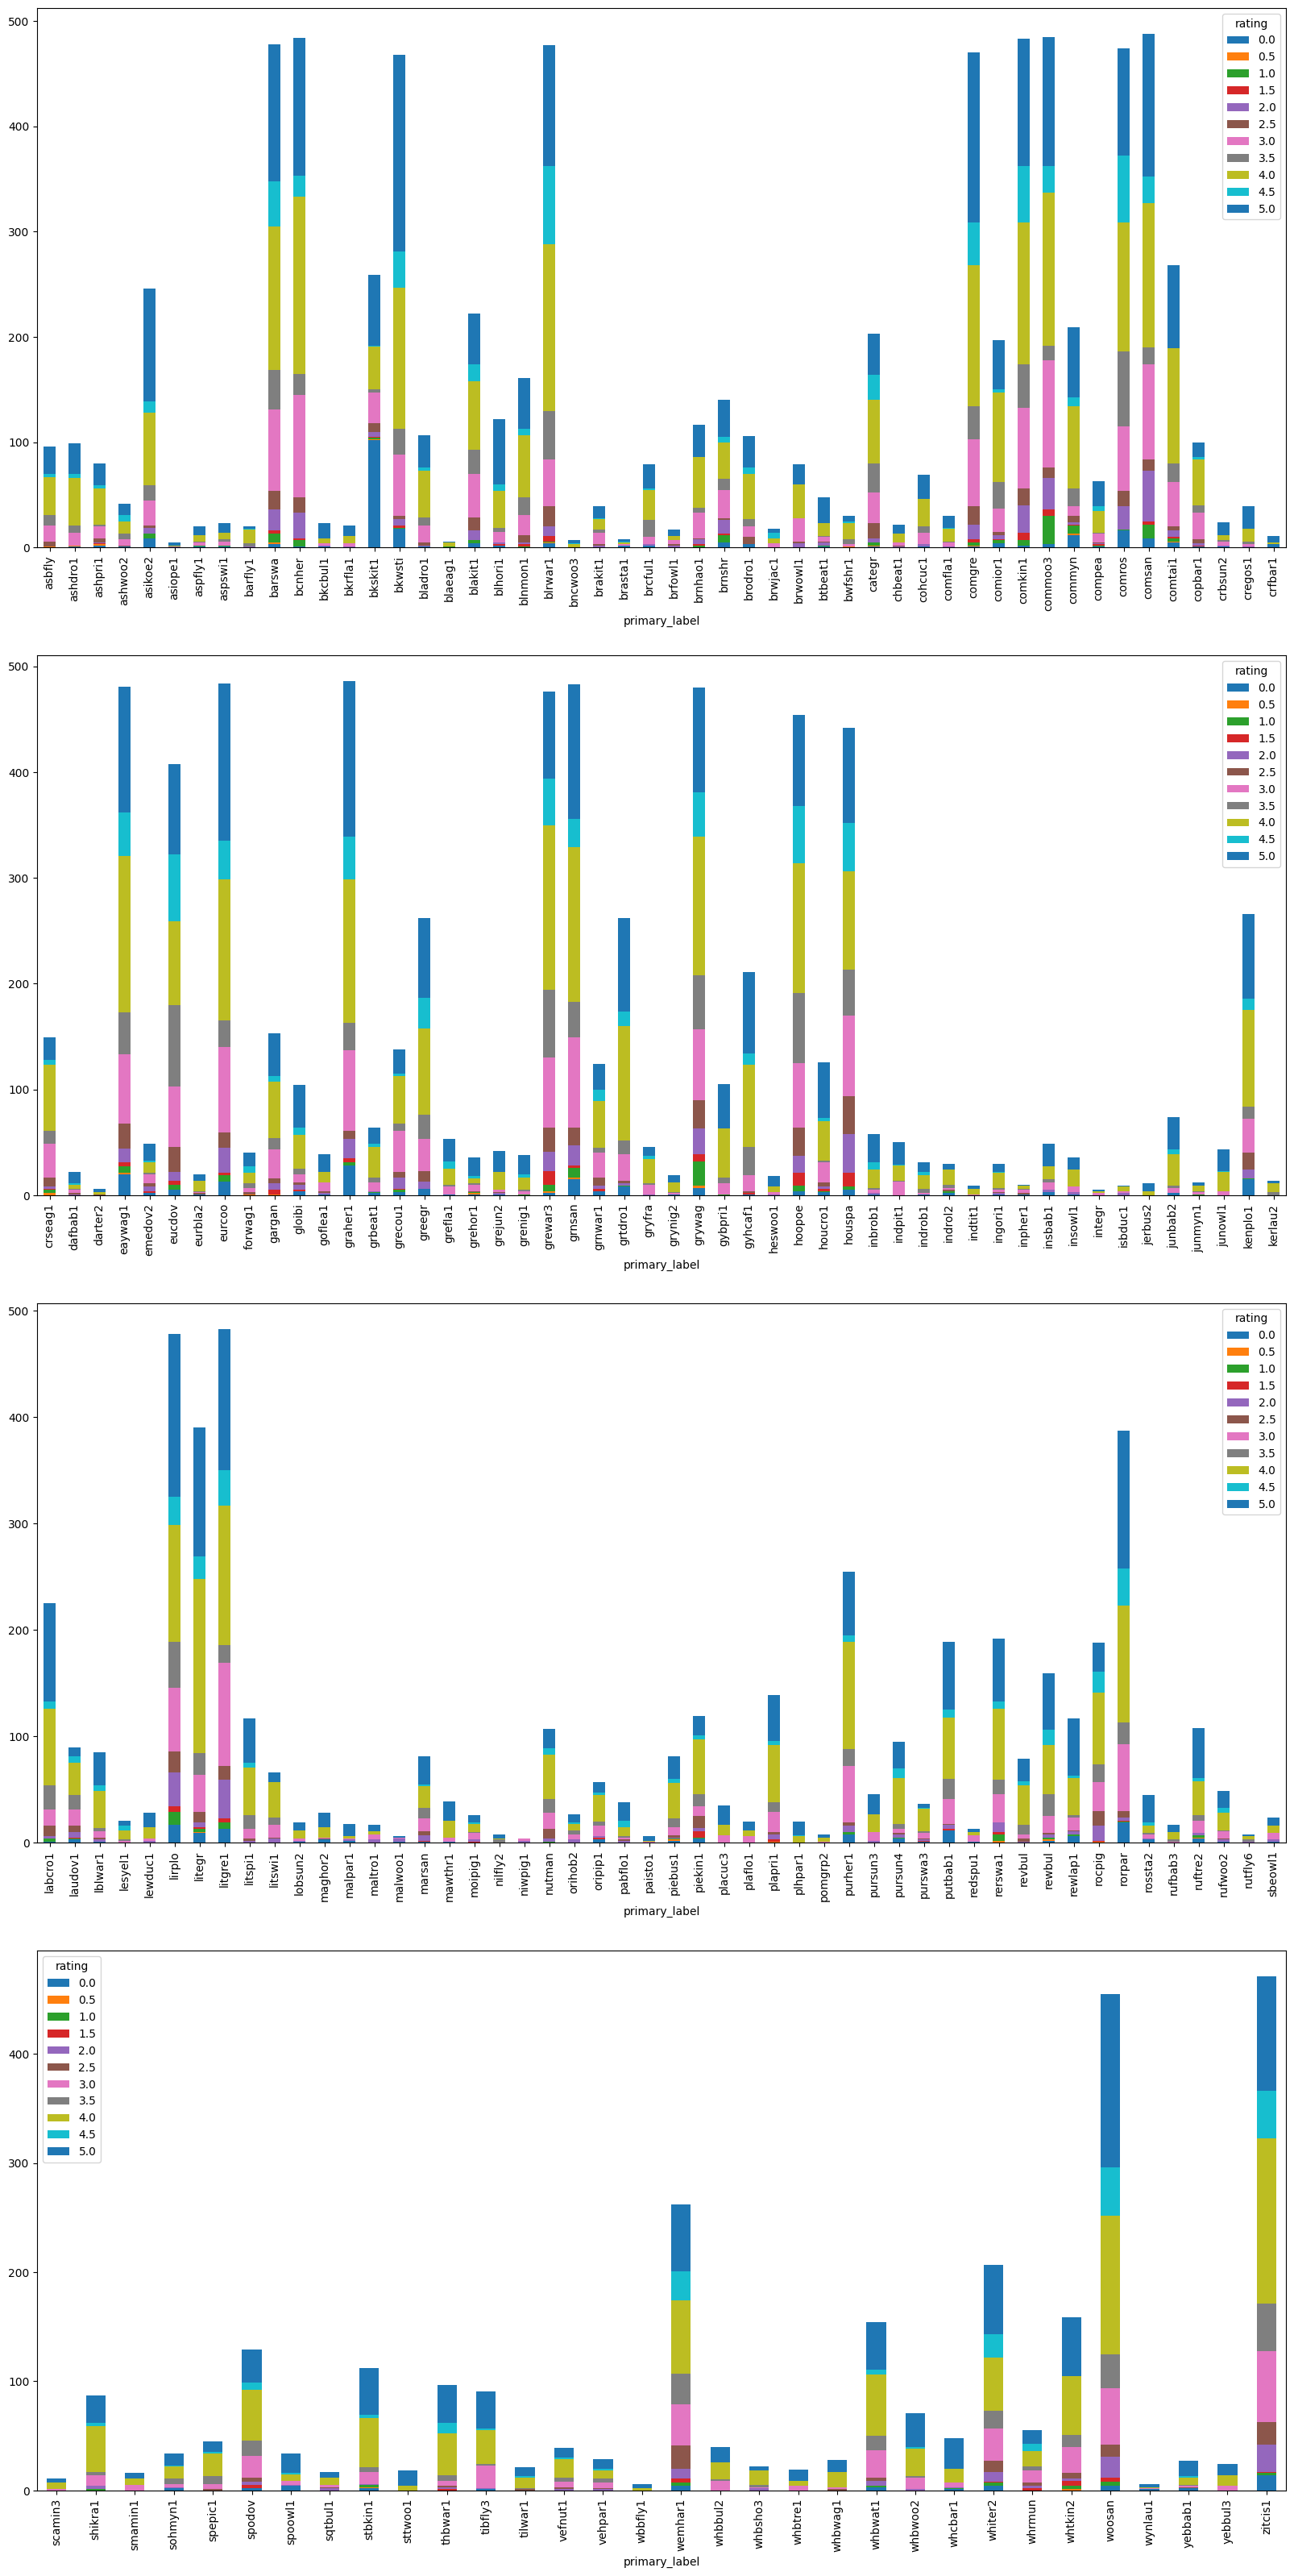

In [5]:
# group by primary label and make a bar plot of the asbfly rating value_counts
# train.groupby('primary_label')['rating'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(20,10))

# this is too cramped, split the birds into groups of 50, and make the same plot as a 4 row x 1 column subplot
fig, axs = plt.subplots(4, 1, figsize=(20,40))
for i in range(4):
    train.groupby('primary_label')['rating'].value_counts().unstack().iloc[i*50:(i+1)*50].plot(kind='bar', stacked=True, ax=axs[i])
    
plt.show()


<Axes: xlabel='primary_label'>

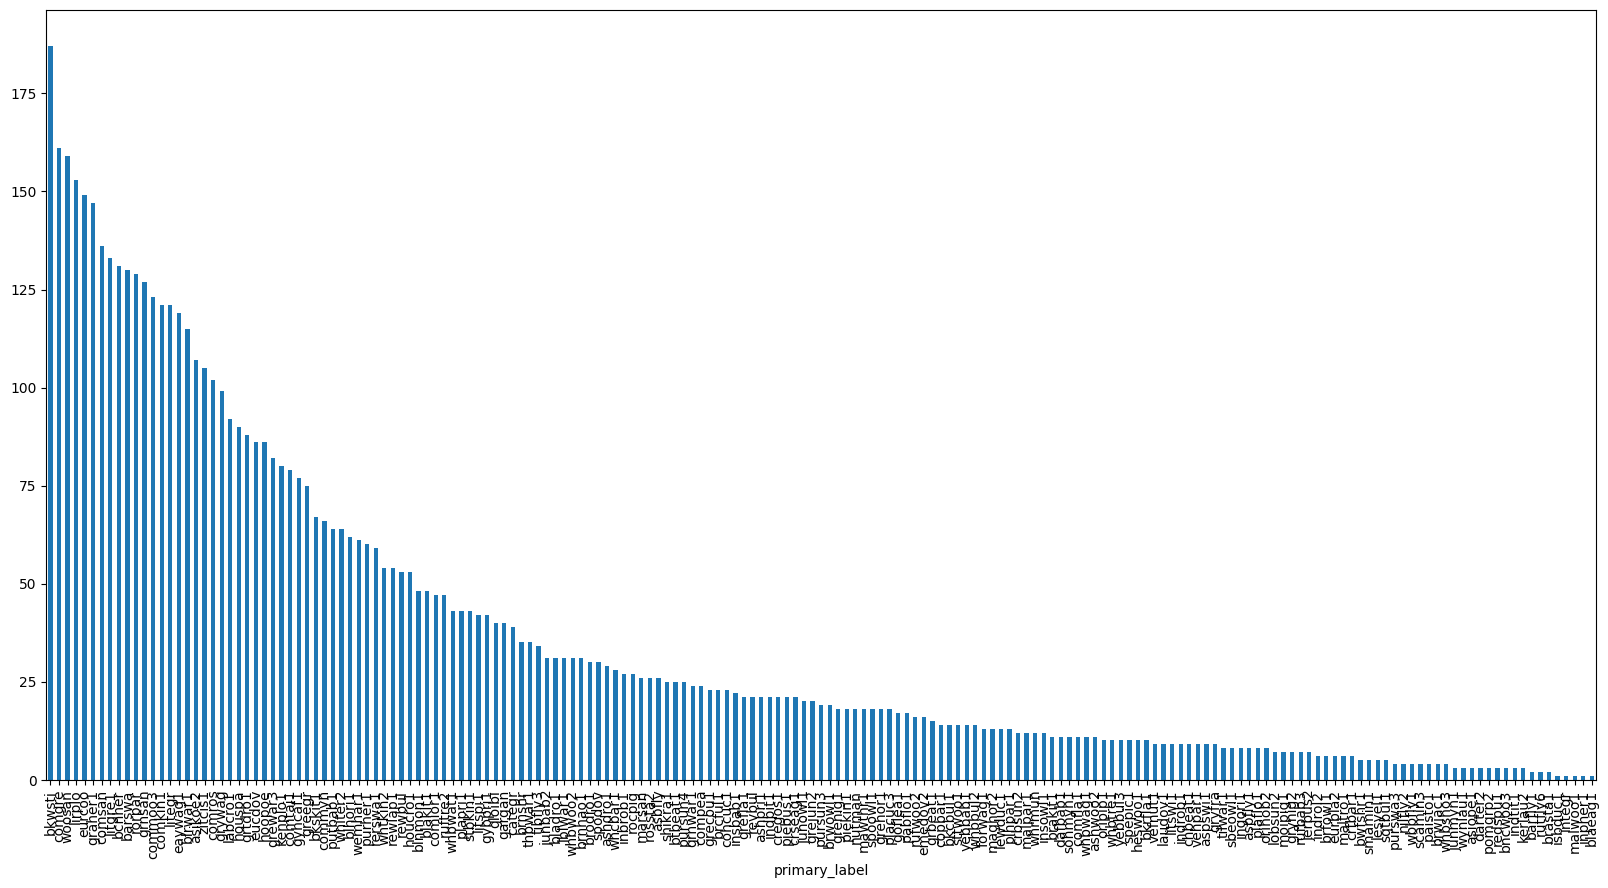

In [6]:
# count the number of rating = 5 for each primary label
train[train['rating'] == 5].groupby('primary_label').size().sort_values(ascending=False)

# plot as a bar chart
train[train['rating'] == 5].groupby('primary_label').size().sort_values(ascending=False).plot(kind='bar', figsize=(20,10))


In [7]:
# do all birds have at least one rating of 5?
train.groupby('primary_label')['rating'].max().value_counts()


rating
5.0    181
3.0      1
Name: count, dtype: int64

In [8]:
# keep only ratings 2, 3, 4, and 5
train = train[train['rating'] >= 3.0]
print(f'Train shape: {train.shape}')
# still 20053 rows, so only about 10% were lower than 3, and about 5% were lower than 2

Train shape: (20053, 7)


In [9]:
# what is the least 10 value counts of a primary label?
train['primary_label'].value_counts().tail(10)


primary_label
paisto1    6
brasta1    6
wbbfly1    6
darter2    5
integr     5
wynlau1    5
blaeag1    5
asiope1    4
niwpig1    2
malwoo1    2
Name: count, dtype: int64

In [10]:
# what is the number of unique primary labels?  Do I still have 182?
train['primary_label'].nunique()


182

In [11]:
# start with a small subset of the data, only the first primary label
train_asbfly = train[train['primary_label'] == 'asbfly']
print(f'Train asbfly shape: {train_asbfly.shape}')
train_asbfly.head()

Train asbfly shape: (90, 7)


,primary_label,type,latitude,longitude,common_name,rating,filename
0,asbfly,['call'],39.2297,118.1987,Asian Brown Flycatcher,5.0,asbfly/XC134896.ogg
3,asbfly,['call'],21.1697,70.6005,Asian Brown Flycatcher,4.0,asbfly/XC207738.ogg
4,asbfly,['call'],15.5442,73.7733,Asian Brown Flycatcher,4.0,asbfly/XC209218.ogg
5,asbfly,['call'],15.5442,73.7733,Asian Brown Flycatcher,4.0,asbfly/XC209219.ogg
6,asbfly,['clicks its bill'],42.5275,130.6920,Asian Brown Flycatcher,3.0,asbfly/XC267679.ogg


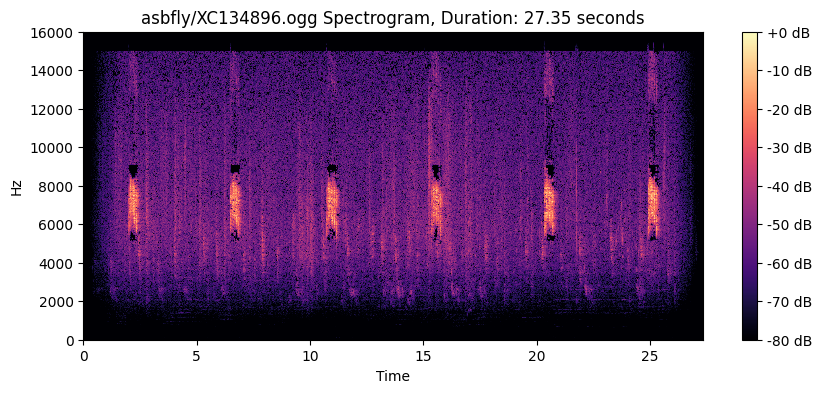

In [12]:
# open the first filename in the asbfly subset
filename = train_asbfly['filename'].iloc[0]

# load the audio file
y, sr = librosa.load(f'{root_dir}train_audio/{filename}', sr=None)

# get the duration of the audio file
duration = librosa.get_duration(y=y, sr=sr)
    
# get the spectrogram of the audio file
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    
# plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'{filename} Spectrogram, Duration: {duration:.2f} seconds')
plt.show()

# Create Directories

In [13]:
# check if the spectrograms folder exists, if not create it
if not os.path.exists('/kaggle/working/spectrograms'):
    os.makedirs('/kaggle/working//spectrograms', exist_ok=True)

# create subfolders under the spectrograms folder for each primary label
for primary_label in train['primary_label'].unique():
    # check if the primary label folder exists, if not create it
    if not os.path.exists(f'/kaggle/working//spectrograms/{primary_label}'):
        os.makedirs(f'/kaggle/working//spectrograms/{primary_label}', exist_ok=True)
    

# Function to load, process, and save spectrograms

In [14]:
# create a function that will take a filename, split it into 5 second intervals, and save the spectrograms as images, with a threshold for the minimum decibel level

def save_spectrograms(filename, interval_length=5, threshold_mult=.10,make_plots=False):

    removed_count = 0
    
    # load the audio file
    y, sr = librosa.load(f'{root_dir}train_audio/{filename}', sr=None)
    
    # get the duration of the audio file
    duration = librosa.get_duration(y=y, sr=sr)
    
    # get the number of intervals
    num_intervals = int(np.floor(duration / interval_length))
    
    # get the number of samples in each interval
    samples_per_interval = int(interval_length * sr)
    
    # get the max and min of the whole audio file
    max_y = np.max(y)
    min_y = np.min(y)
    range_y = max_y - min_y
    
    # print the relevant parameters of the file
    #print(f'Filename: {filename}, duration: {duration:.2f} sec, num_intervals: {num_intervals}, samples_per_interval: {samples_per_interval}, Range: {range_y}')
    
    # loop through the intervals and take the spectrogram of each
    for i in range(num_intervals):
        
        # get the start and end samples for the interval
        start_sample = i * samples_per_interval
        end_sample = (i + 1) * samples_per_interval
        
        # get the interval audio
        y_interval = y[start_sample:end_sample]
        
        # get the max and min of the interval
        max_y_interval = np.max(y_interval)
        min_y_interval = np.min(y_interval)
        range_y_interval = max_y_interval - min_y_interval
        
        # if the range of the interval is less than the threshold, skip it
        if range_y_interval < threshold_mult * range_y:
            print(f'Filename: {filename}, duration: {duration:.2f} sec, Range: {range_y}, Range y interval: {range_y_interval}, ratio: {range_y_interval/range_y}')
            plt.figure(figsize=(12,3))
            librosa.display.waveshow(y, sr=sr,color="blue",alpha=0.5)
            librosa.display.waveshow(y_interval, sr=sr,color="red",alpha=0.5)
            removed_count += 1
            
            plt.show()
            continue
            
        # get the interval spectrogram
        D_interval = librosa.amplitude_to_db(np.abs(librosa.stft(y_interval)), ref=np.max) # maybe want an absolute here
        
        # resize to 224x224 pixels
        D_interval = cv2.resize(D_interval, (224, 224))

        # plot the interval spectrogram
        if make_plots:
            plt.figure()
            plt.imshow(D_interval, aspect='auto', origin='lower', cmap='gray')
            plt.axis('off')
            plt.show()
            
        if removed_count > 0: 
            print(f'Removed: {removed_count}')
        
        # save the interval spectrogram as an image
        plt.imsave(f'./spectrograms/{filename[0:-4]}_{i+1}.jpg', D_interval, cmap='gray')
        
    return removed_count
        
    
# test the function on the first filename in the asbfly subset
save_spectrograms(train_asbfly['filename'].iloc[1])

0

asbfly/XC134896.ogg, count 0, spectrograms saved
asbfly/XC207738.ogg, count 1, spectrograms saved
asbfly/XC209218.ogg, count 2, spectrograms saved
asbfly/XC209219.ogg, count 3, spectrograms saved
asbfly/XC267679.ogg, count 4, spectrograms saved
asbfly/XC267680.ogg, count 5, spectrograms saved
asbfly/XC267681.ogg, count 6, spectrograms saved
asbfly/XC267682.ogg, count 7, spectrograms saved
asbfly/XC267683.ogg, count 8, spectrograms saved
asbfly/XC291450.ogg, count 9, spectrograms saved
asbfly/XC305518.ogg, count 10, spectrograms saved
asbfly/XC309402.ogg, count 11, spectrograms saved
asbfly/XC312456.ogg, count 12, spectrograms saved
asbfly/XC313835.ogg, count 13, spectrograms saved
asbfly/XC329259.ogg, count 14, spectrograms saved
asbfly/XC341611.ogg, count 15, spectrograms saved
asbfly/XC341612.ogg, count 16, spectrograms saved
asbfly/XC342037.ogg, count 17, spectrograms saved
asbfly/XC342638.ogg, count 18, spectrograms saved
asbfly/XC347563.ogg, count 19, spectrograms saved
asbfly/XC3

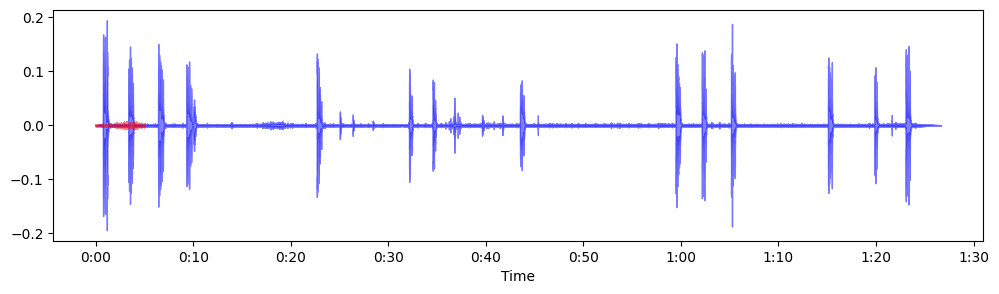

Removed: 1
Removed: 1
Removed: 1
Removed: 1
Removed: 1
Filename: asbfly/XC596043.ogg, duration: 86.67 sec, Range: 0.3602718114852905, Range y interval: 0.03289264440536499, ratio: 0.09129951894283295


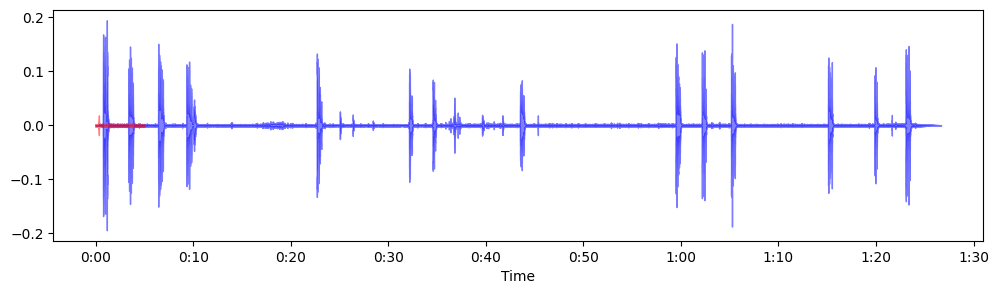

Filename: asbfly/XC596043.ogg, duration: 86.67 sec, Range: 0.3602718114852905, Range y interval: 0.010289272293448448, ratio: 0.028559748083353043


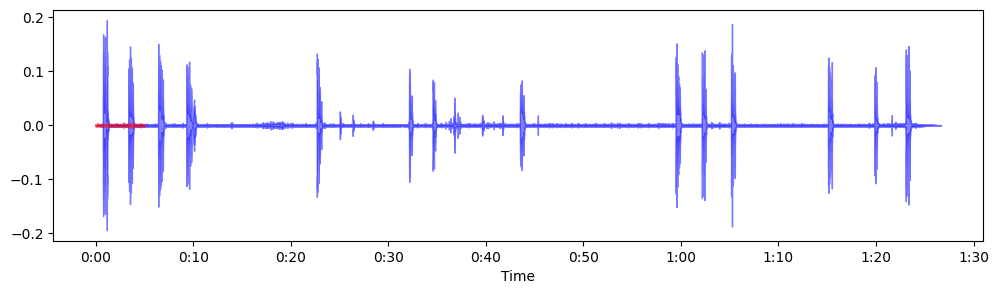

Removed: 3
Removed: 3
Removed: 3
Filename: asbfly/XC596043.ogg, duration: 86.67 sec, Range: 0.3602718114852905, Range y interval: 0.007082052528858185, ratio: 0.019657526165246964


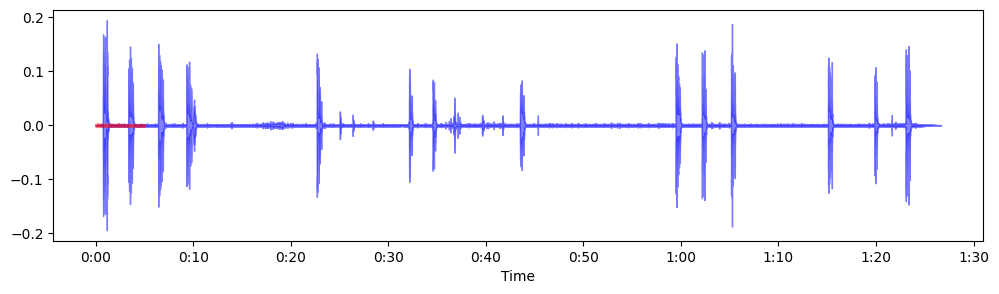

Removed: 4
Removed: 4
asbfly/XC596043.ogg, count 38, spectrograms saved
asbfly/XC610733.ogg, count 39, spectrograms saved
asbfly/XC610734.ogg, count 40, spectrograms saved
asbfly/XC610735.ogg, count 41, spectrograms saved
asbfly/XC629846.ogg, count 42, spectrograms saved
asbfly/XC629847.ogg, count 43, spectrograms saved
asbfly/XC647397.ogg, count 44, spectrograms saved
asbfly/XC665386.ogg, count 45, spectrograms saved
asbfly/XC684073.ogg, count 46, spectrograms saved
asbfly/XC687953.ogg, count 47, spectrograms saved
asbfly/XC712207.ogg, count 48, spectrograms saved
asbfly/XC713467.ogg, count 49, spectrograms saved
asbfly/XC713503.ogg, count 50, spectrograms saved
asbfly/XC716486.ogg, count 51, spectrograms saved
asbfly/XC716692.ogg, count 52, spectrograms saved
Filename: asbfly/XC716727.ogg, duration: 38.16 sec, Range: 0.20508559048175812, Range y interval: 0.014261489734053612, ratio: 0.06953921169042587


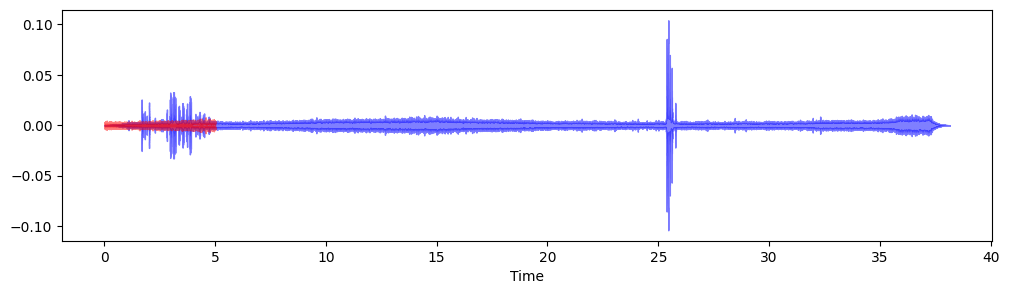

Filename: asbfly/XC716727.ogg, duration: 38.16 sec, Range: 0.20508559048175812, Range y interval: 0.019550183787941933, ratio: 0.09532695263624191


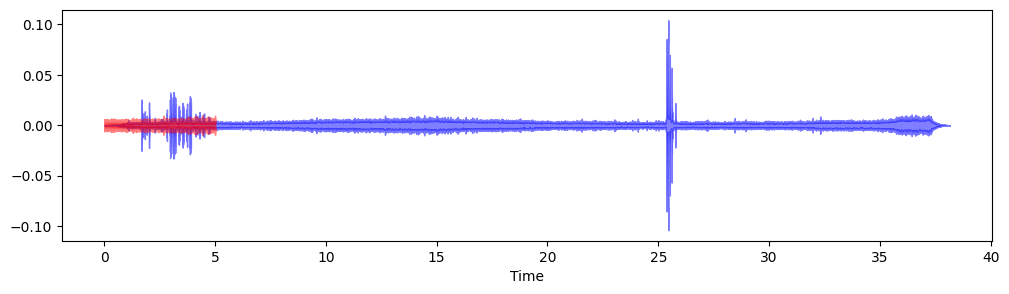

Filename: asbfly/XC716727.ogg, duration: 38.16 sec, Range: 0.20508559048175812, Range y interval: 0.01700519025325775, ratio: 0.08291752636432648


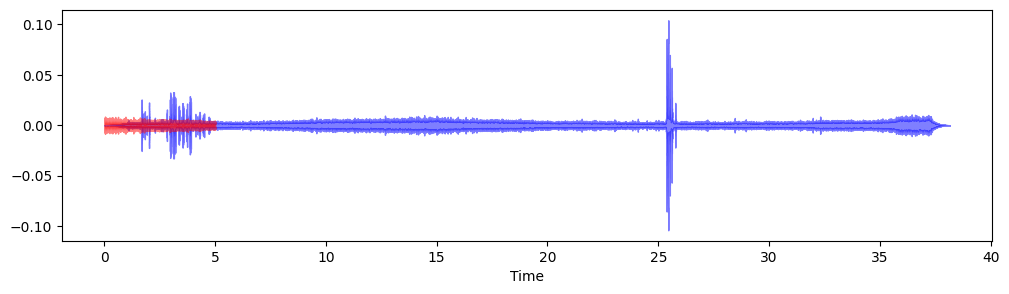

Filename: asbfly/XC716727.ogg, duration: 38.16 sec, Range: 0.20508559048175812, Range y interval: 0.012596112675964832, ratio: 0.0614188089966774


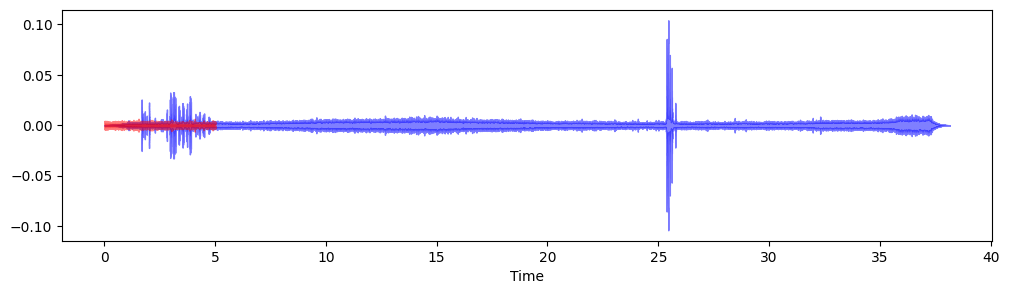

Removed: 4
Filename: asbfly/XC716727.ogg, duration: 38.16 sec, Range: 0.20508559048175812, Range y interval: 0.01710868440568447, ratio: 0.08342216908931732


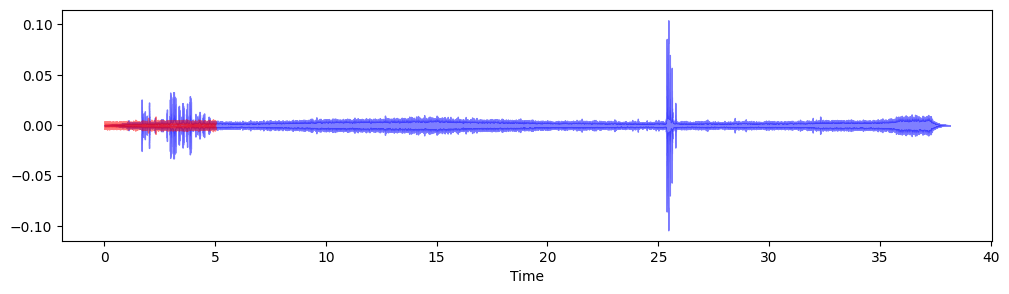

asbfly/XC716727.ogg, count 53, spectrograms saved
asbfly/XC716737.ogg, count 54, spectrograms saved
Filename: asbfly/XC716738.ogg, duration: 31.45 sec, Range: 0.5630013346672058, Range y interval: 0.014306312426924706, ratio: 0.02541079744696617


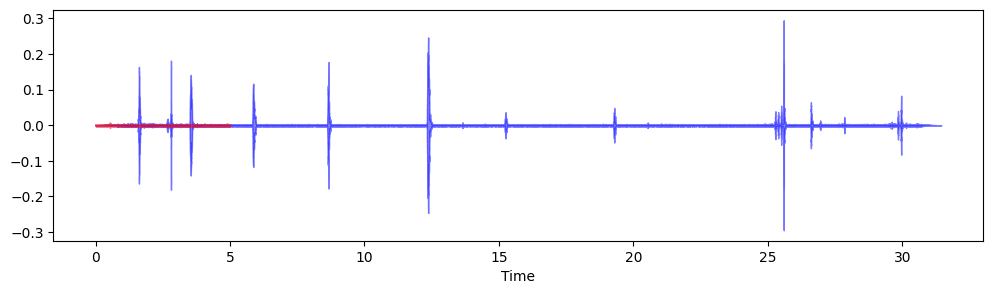

Removed: 1
asbfly/XC716738.ogg, count 55, spectrograms saved
asbfly/XC716740.ogg, count 56, spectrograms saved
asbfly/XC718355.ogg, count 57, spectrograms saved
Filename: asbfly/XC724148.ogg, duration: 146.63 sec, Range: 0.4566335082054138, Range y interval: 0.04306302219629288, ratio: 0.09430543333292007


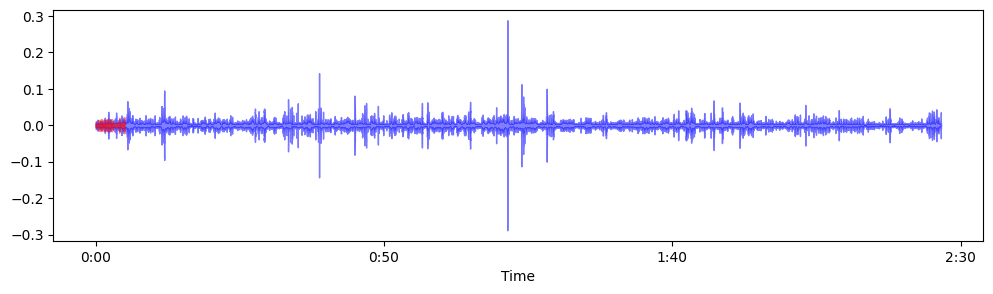

Removed: 1
Filename: asbfly/XC724148.ogg, duration: 146.63 sec, Range: 0.4566335082054138, Range y interval: 0.042914338409900665, ratio: 0.09397982805967331


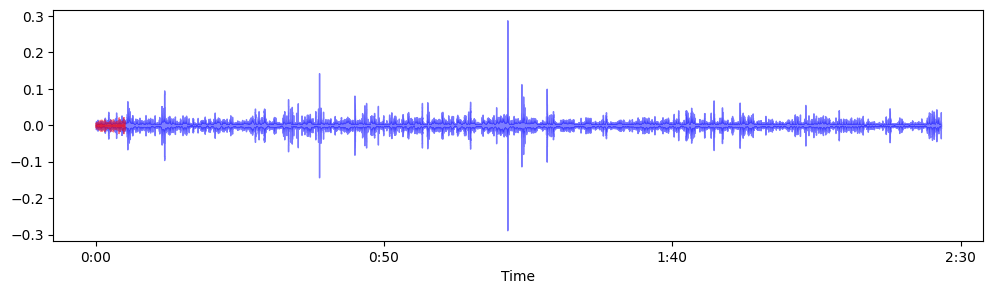

Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
asbfly/XC724148.ogg, count 58, spectrograms saved
Filename: asbfly/XC724266.ogg, duration: 146.63 sec, Range: 0.4566335082054138, Range y interval: 0.04336583986878395, ratio: 0.09496858716011047


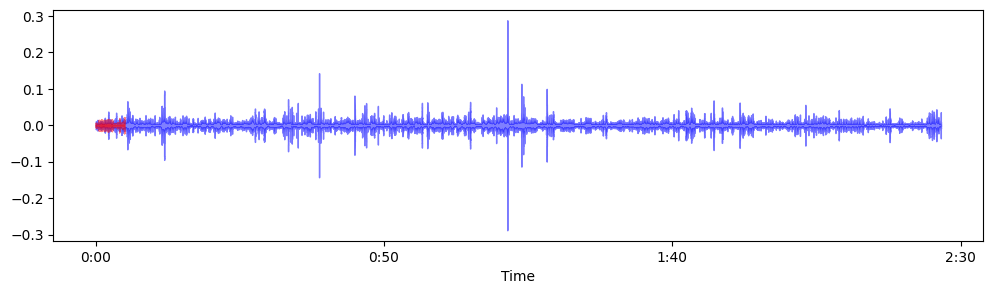

Removed: 1
Filename: asbfly/XC724266.ogg, duration: 146.63 sec, Range: 0.4566335082054138, Range y interval: 0.042959943413734436, ratio: 0.09407970309257507


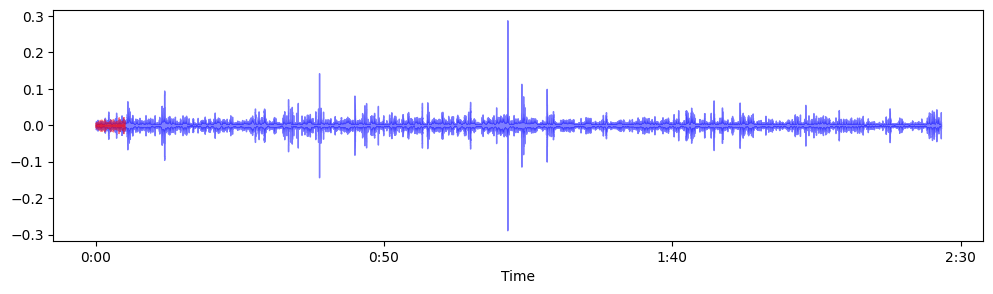

Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
asbfly/XC724266.ogg, count 59, spectrograms saved
asbfly/XC741062.ogg, count 60, spectrograms saved
asbfly/XC741066.ogg, count 61, spectrograms saved
asbfly/XC741067.ogg, count 62, spectrograms saved
asbfly/XC745831.ogg, count 63, spectrograms saved
asbfly/XC749597.ogg, count 64, spectrograms saved
asbfly/XC756431.ogg, count 65, spectrograms saved
asbfly/XC756532.ogg, count 66, spectrograms saved
asbfly/XC756617.ogg, count 67, spectrograms saved
asbfly/XC767510.ogg, count 68, spectrograms saved
asbfly/XC770506.ogg, count 69, spectrograms saved
asbfly/XC770507.ogg, count 70, spectrograms saved
asbfly/XC775904.ogg, count 71, spectrograms saved
asbfly/XC778686.ogg, count 72, spectrograms saved
asbfly/XC778717.ogg, count 73, spectrograms saved
asbfly/XC785503.ogg, count 74, spectrograms saved
asbfly/XC805713.ogg, count 75, spectrograms saved
Filename: asbfly/XC818340.ogg, duration:

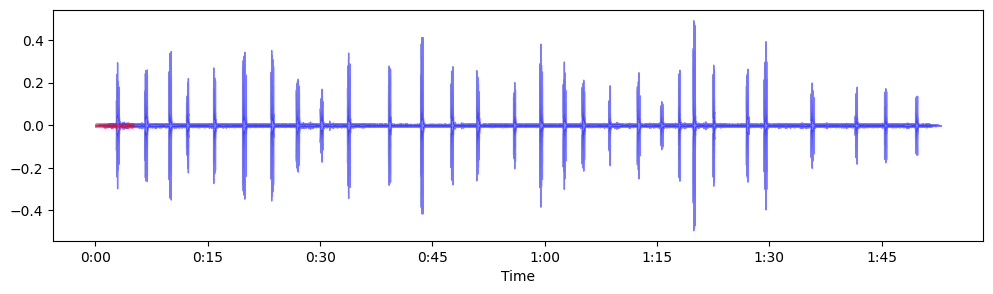

Removed: 1
Removed: 1
Removed: 1
asbfly/XC818340.ogg, count 76, spectrograms saved
Filename: asbfly/XC821773.ogg, duration: 84.30 sec, Range: 0.6115033626556396, Range y interval: 0.046547502279281616, ratio: 0.07611978054046631


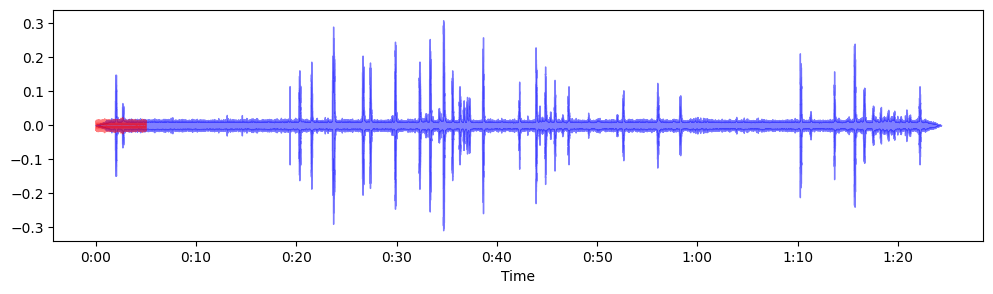

Filename: asbfly/XC821773.ogg, duration: 84.30 sec, Range: 0.6115033626556396, Range y interval: 0.05995022505521774, ratio: 0.09803744405508041


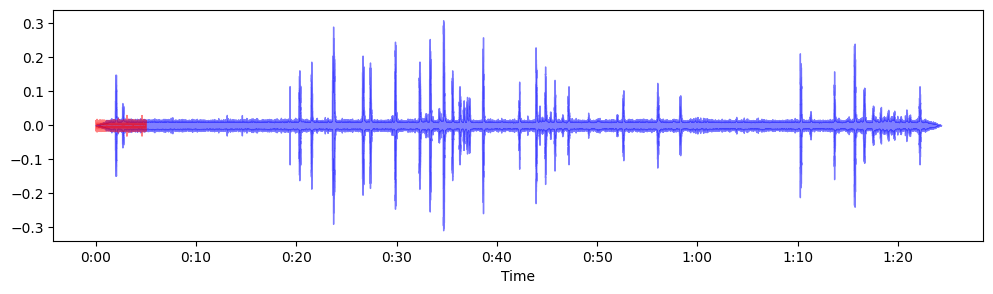

Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Removed: 2
Filename: asbfly/XC821773.ogg, duration: 84.30 sec, Range: 0.6115033626556396, Range y interval: 0.04720218479633331, ratio: 0.07719039171934128


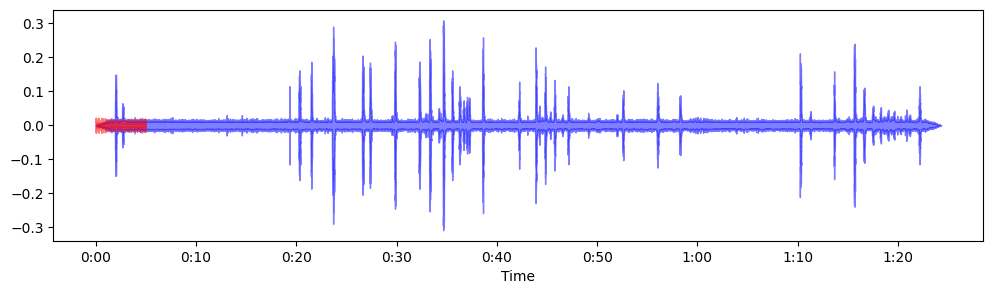

Filename: asbfly/XC821773.ogg, duration: 84.30 sec, Range: 0.6115033626556396, Range y interval: 0.04342293739318848, ratio: 0.07101013511419296


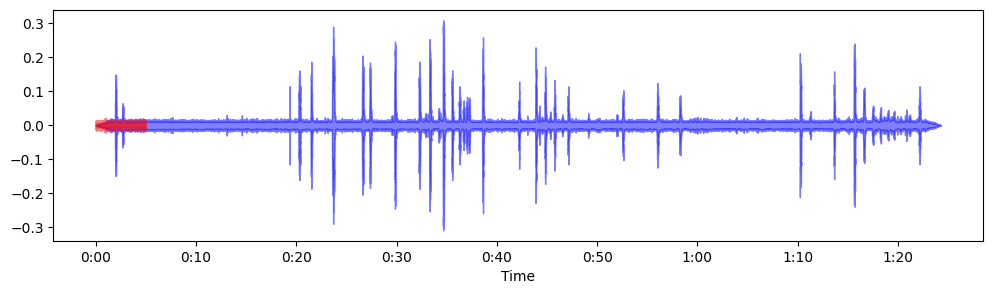

Removed: 4
Removed: 4
asbfly/XC821773.ogg, count 77, spectrograms saved
asbfly/XC825177.ogg, count 78, spectrograms saved
asbfly/XC827640.ogg, count 79, spectrograms saved
asbfly/XC830258.ogg, count 80, spectrograms saved
asbfly/XC833987.ogg, count 81, spectrograms saved
asbfly/XC834959.ogg, count 82, spectrograms saved
asbfly/XC837545.ogg, count 83, spectrograms saved
Filename: asbfly/XC839572.ogg, duration: 97.87 sec, Range: 0.13817653059959412, Range y interval: 0.010380774736404419, ratio: 0.07512690126895905


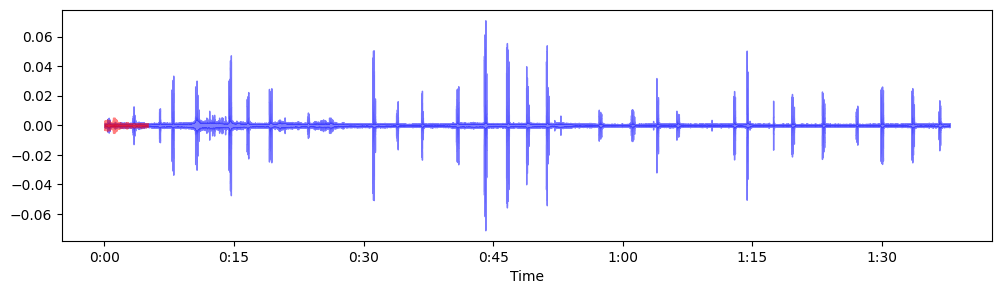

Removed: 1
Removed: 1
Removed: 1
Removed: 1
Removed: 1
Removed: 1
Removed: 1
Removed: 1
Removed: 1
Removed: 1
Removed: 1
Removed: 1
Removed: 1
asbfly/XC839572.ogg, count 84, spectrograms saved
asbfly/XC842684.ogg, count 85, spectrograms saved
asbfly/XC842686.ogg, count 86, spectrograms saved
Filename: asbfly/XC846616.ogg, duration: 66.91 sec, Range: 0.6124157905578613, Range y interval: 0.02615729160606861, ratio: 0.04271165281534195


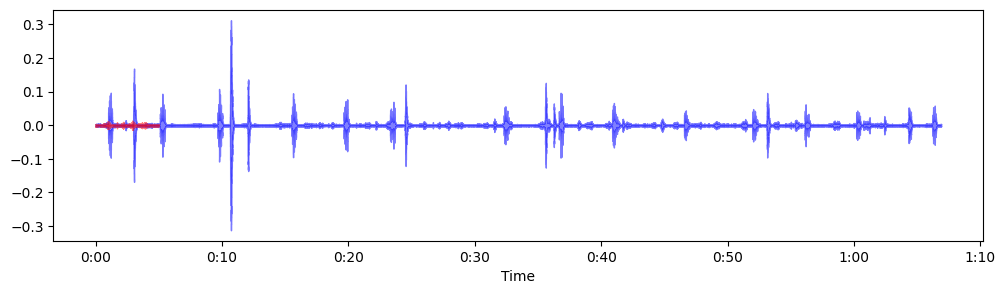

Removed: 1
Removed: 1
Removed: 1
Removed: 1
Removed: 1
Removed: 1
Removed: 1
asbfly/XC846616.ogg, count 87, spectrograms saved
asbfly/XC856776.ogg, count 88, spectrograms saved
asbfly/XC858110.ogg, count 89, spectrograms saved


In [15]:
# loop through the train_asbfly dataframe and save the spectrograms as images
for i in range(train_asbfly.shape[0]):
    filename = train_asbfly['filename'].iloc[i]
    save_spectrograms(filename)
    print(f'{filename}, count {i}, spectrograms saved')